# odm2api demo with Little Bear SQLite sample DB
Largely from https://github.com/ODM2/ODM2PythonAPI/blob/master/Examples/Sample.py   
- 4/25/2016. Started testing with the new `odm2` conda channel, based on the new `0.5.0-alpha` odm2api release. See my `odm2api_odm2channel` env. Ran into problems b/c the SQLite database needed to be updated to have a `SamplingFeature.FeatureGeometryWKT` field; so I added and populated it manually with `SQLite Manager`.
- 2/7/2016. Tested successfully with `sfgeometry_em_1` branch, with my overhauls. Using `odm2api_dev` env.
- 2/1 - 1/31. Errors with SamplingFeatures code, with latest odm2api from master (on env `odm2api_jan31test`). *The code also fails the same way with the `odm2api` env, but it does still run fine with the `odm2api_jan21` env! I'm investigating the differences between those two envs.*
- 1/22-20,9/2016.

Author: Emilio Mayorga

### Create a connection to the ODM2 database

In [1]:
from odm2api.ODMconnection import dbconnection

odm2db_fpth = 'data/ODM2-LittleBear1.sqlite'

session_factory = dbconnection.createConnection('sqlite', odm2db_fpth, 2.0)

### Read the database

In [2]:
from odm2api.ODM2.services.readService import ReadODM2

read = ReadODM2(session_factory)

### Run some basic sample queries

In [3]:
allVars = read.getVariables()

for x in allVars:
    print("{}: {}".format(x.VariableCode, x.VariableNameCV))

USU36: Temperature


### Read some metadata from the database: people and affiliation

In [4]:
allPeople = read.getPeople()

if allPeople:
    for x in allPeople:
        print("{} {}".format(x.PersonFirstName, x.PersonLastName))
        
allaff = read.getAffiliations()

if allaff:
    for x in allaff:
        print("{}: {}".format(x.PersonObj.PersonFirstName, x.OrganizationID))

Jeff Horsburgh


## SamplingFeatures tests

### Get all of the SamplingFeatures from the database that are Sites

In [5]:
try:
    siteFeatures = read.getSamplingFeatures(type='Site')
    numSites = len(siteFeatures)
    for x in siteFeatures:
        print x.SamplingFeatureCode + ": " + x.SamplingFeatureName
except Exception as e:
    print("Unable to demo getSamplingFeatures(type='Site')\n{}".format(e))

USU-LBR-Mendon: Little Bear River at Mendon Road near Mendon, Utah


In [6]:
read.getSamplingFeatures()

[<Sites('1', '1', 'Stream', '41.718473', '-111.946402', '<SpatialReferences('1', 'None', 'Unknown', 'The spatial reference is unknown', 'None')>', 'USU-LBR-Mendon')>]

In [7]:
read.getSamplingFeatures(codes=['USU-LBR-Mendon'])

[<Sites('1', '1', 'Stream', '41.718473', '-111.946402', '<SpatialReferences('1', 'None', 'Unknown', 'The spatial reference is unknown', 'None')>', 'USU-LBR-Mendon')>]

### Now get the SamplingFeature object for a SamplingFeature code

In [8]:
sf_lst = read.getSamplingFeatures(codes=['USU-LBR-Mendon'])

vars(sf_lst[0])

{'ElevationDatumCV': u'NGVD29',
 'Elevation_m': 1345.0,
 'FeatureGeometry': <SQLitePersistentSpatialElement at 0x7f234e2cabd0; <WKBSpatialElement at 0x7f234e2ca610; u'POINT (41.718473 -111.946402)'>>,
 'FeatureGeometryWKT': u'POINT (41.718473 -111.946402)',
 'Latitude': 41.718473,
 'Longitude': -111.946402,
 'SamplingFeatureCode': u'USU-LBR-Mendon',
 'SamplingFeatureDescription': None,
 'SamplingFeatureGeotypeCV': u'Point',
 'SamplingFeatureID': 1,
 'SamplingFeatureName': u'Little Bear River at Mendon Road near Mendon, Utah',
 'SamplingFeatureTypeCV': u'Site',
 'SamplingFeatureUUID': u'6ae9eceb-989d-11e5-a9c7-6c4008bf018e',
 'SiteTypeCV': u'Stream',
 'SpatialReferenceID': 1,
 'SpatialReferenceObj': <SpatialReferences('1', 'None', 'Unknown', 'The spatial reference is unknown', 'None')>,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f234e31ba90>}

In [9]:
sf = sf_lst[0]

sf

<Sites('1', '1', 'Stream', '41.718473', '-111.946402', '<SpatialReferences('1', 'None', 'Unknown', 'The spatial reference is unknown', 'None')>', 'USU-LBR-Mendon')>

In [10]:
print(type(sf))
print(type(sf.FeatureGeometryWKT), sf.FeatureGeometryWKT)
print(type(sf.FeatureGeometry))

<class 'odm2api.ODM2.models.Sites'>
(<type 'unicode'>, u'POINT (41.718473 -111.946402)')
<class 'geoalchemy.spatialite.SQLitePersistentSpatialElement'>


In [11]:
vars(sf.FeatureGeometry)

{'desc': <WKBSpatialElement at 0x7f234e2ca610; u'POINT (41.718473 -111.946402)'>}

In [12]:
sf.FeatureGeometry.__doc__

'Represents a Geometry value as loaded from the database.'

In [13]:
sf.FeatureGeometry.geom_wkb, sf.FeatureGeometry.geom_wkt

(u'POINT (41.718473 -111.946402)', None)

In [14]:
# 4/25/2016: Don't know why the shape is listed 4 times...
type(sf.shape()), sf.shape().wkt

POINT (41.718473 -111.946402)
POINT (41.718473 -111.946402)
POINT (41.718473 -111.946402)
POINT (41.718473 -111.946402)


(shapely.geometry.point.Point, 'POINT (41.718473 -111.946402)')

## Back to the rest of the demo

In [15]:
read.getResults()

[<TimeSeriesResults('1', 'None', 'None', 'None', 'Time series coverage', 'None', 'None', '30.0', 'Average')>]

In [16]:
firstResult = read.getResults()[0]

firstResult.FeatureActionObj.ActionObj

<Actions('1', 'Observation', '2007-08-16 16:30:00', 'An observation action that generated a time series result.')>

### Foreign Key Example

Drill down and get objects linked by foreign keys

In [17]:
try:
    # Call getResults, but return only the first result.
    firstResult = read.getResults()[0]
    action_firstResult = firstResult.FeatureActionObj.ActionObj
    print("The FeatureAction object for the Result is: {}".format(firstResult.FeatureActionObj))
    print("The Action object for the Result is: {}".format(action_firstResult))
    print("\nThe following are some of the attributes for the Action that created the Result: \n" +
          "ActionTypeCV: " + action_firstResult.ActionTypeCV + "\n" +
          "ActionDescription: " + action_firstResult.ActionDescription + "\n" +
          "BeginDateTime: " + str(action_firstResult.BeginDateTime) + "\n" +
          "EndDateTime: " + str(action_firstResult.EndDateTime) + "\n" +
          "MethodName: " + action_firstResult.MethodObj.MethodName + "\n" +
          "MethodDescription: " + action_firstResult.MethodObj.MethodDescription)
except Exception as e:
    print("Unable to demo Foreign Key Example: {}".format(e))

The FeatureAction object for the Result is: <FeatureActions('1', '1', '1', )>
The Action object for the Result is: <Actions('1', 'Observation', '2007-08-16 16:30:00', 'An observation action that generated a time series result.')>

The following are some of the attributes for the Action that created the Result: 
ActionTypeCV: Observation
ActionDescription: An observation action that generated a time series result.
BeginDateTime: 2007-08-16 16:30:00
EndDateTime: 2009-01-16 12:30:00
MethodName: Quality Control Level 1 Data Series created from raw QC Level 0 data using ODM Tools.
MethodDescription: Quality Control Level 1 Data Series created from raw QC Level 0 data using ODM Tools.


### Example of Retrieving Attributes of a Time Series Result using a ResultID

In [18]:
tsResult = read.getResults(ids=[1])[0]

type(tsResult), vars(tsResult)

(odm2api.ODM2.models.TimeSeriesResults,
 {'AggregationStatisticCV': u'Average',
  'FeatureActionID': 1,
  'FeatureActionObj': <FeatureActions('1', '1', '1', )>,
  'IntendedTimeSpacing': 30.0,
  'IntendedTimeSpacingUnitsID': 102,
  'ProcessingLevelID': 1,
  'ResultDateTime': datetime.datetime(2015, 12, 1, 19, 35, 57, 609318),
  'ResultDateTimeUTCOffset': -7,
  'ResultID': 1,
  'ResultTypeCV': u'Time series coverage',
  'ResultUUID': u'6af05c61-989d-11e5-9d19-6c4008bf018e',
  'SampledMediumCV': u'Surface Water',
  'SpatialReferenceID': None,
  'SpatialReferenceObj': None,
  'StatusCV': u'Unknown',
  'TaxonomicClassifierID': None,
  'UnitsID': 96,
  'ValidDateTime': None,
  'ValidDateTimeUTCOffset': None,
  'ValueCount': 24206,
  'VariableID': 1,
  'XLocation': None,
  'XLocationUnitsID': None,
  'XLocationUnitsObj': None,
  'YLocation': None,
  'YLocationUnitsID': None,
  'ZLocation': None,
  'ZLocationUnitsID': None,
  '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f234

**Why are `ProcessingLevelObj`, `VariableObj` and `UnitsObj` objects not shown in the above `vars()` listing!?** They **are** actually available, as demonstrated in much of the code below.

In [19]:
try:
    tsResult = read.getResults(ids=[1])[0]
    # Get the site information by drilling down.
    sf_tsResult = tsResult.FeatureActionObj.SamplingFeatureObj
    print("Some of the attributes for the TimeSeriesResult retrieved using getResults(ids=[]): \n" +
          "ResultTypeCV: " + tsResult.ResultTypeCV + "\n" +
          # Get the ProcessingLevel from the TimeSeriesResult's ProcessingLevel object.
          "ProcessingLevel: " + tsResult.ProcessingLevelObj.Definition + "\n" +
          "SampledMedium: " + tsResult.SampledMediumCV + "\n" +
          # Get the variable information from the TimeSeriesResult's Variable object.
          "Variable: " + tsResult.VariableObj.VariableCode + ": " + tsResult.VariableObj.VariableNameCV + "\n" +
          "AggregationStatistic: " + tsResult.AggregationStatisticCV + "\n" +
          # Get the site information by drilling down.
          "Elevation_m: " + str(sf_tsResult.Elevation_m) + "\n" +
          "SamplingFeature: " + sf_tsResult.SamplingFeatureCode + " - " +
          sf_tsResult.SamplingFeatureName)
except Exception as e:
    print("Unable to demo Example of retrieving Attributes of a time Series Result: {}".format(e))

Some of the attributes for the TimeSeriesResult retrieved using getResults(ids=[]): 
ResultTypeCV: Time series coverage
ProcessingLevel: Quality controlled data
SampledMedium: Surface Water
Variable: USU36: Temperature
AggregationStatistic: Average
Elevation_m: 1345.0
SamplingFeature: USU-LBR-Mendon - Little Bear River at Mendon Road near Mendon, Utah


### Example of Retrieving Time Series Result Values, then plotting them

In [20]:
tsValues = read.getResultValues(resultid=1)  # Get the values for a particular TimeSeriesResult.

tsValues.set_index('ValueDateTime', inplace=True)

tsValues.head()  # Return type is a pandas dataframe.

,ValueID,ResultID,DataValue,ValueDateTimeUTCOffset,CensorCodeCV,QualityCodeCV,TimeAggregationInterval,TimeAggregationIntervalUnitsID
ValueDateTime,,,,,,,,
2007-08-16 16:30:00,1,1,22.20000,-7,nc,Unknown,30.0,102
2007-08-16 17:00:00,2,1,22.19833,-7,nc,Unknown,30.0,102
2007-08-16 17:30:00,3,1,22.18500,-7,nc,Unknown,30.0,102
2007-08-16 18:00:00,4,1,22.03833,-7,nc,Unknown,30.0,102
2007-08-16 18:30:00,5,1,21.88167,-7,nc,Unknown,30.0,102


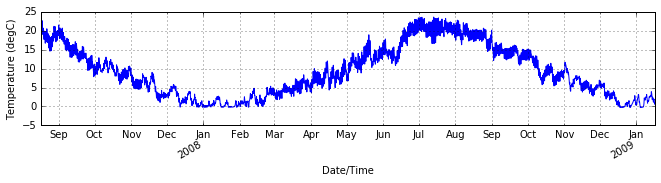

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates

fig, ax = plt.subplots(figsize=(11, 2.25))
tsValues['DataValue'].plot(ax=ax)

title = tsResult.VariableObj.VariableNameCV + " at " +  tsResult.FeatureActionObj.SamplingFeatureObj.SamplingFeatureName

ax.set_ylabel(tsResult.VariableObj.VariableNameCV + " (" +
              tsResult.UnitsObj.UnitsAbbreviation + ")")
ax.set_xlabel("Date/Time")
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%Y'))
ax.grid(which='major', axis='y')
ax.grid(which='minor', axis='x')